In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


In [173]:
df = pd.read_csv('Data/train_cleaned.csv')
df = df.dropna()
X = df.drop(['date','prix'], axis=1)
X.shape

(16112, 19)

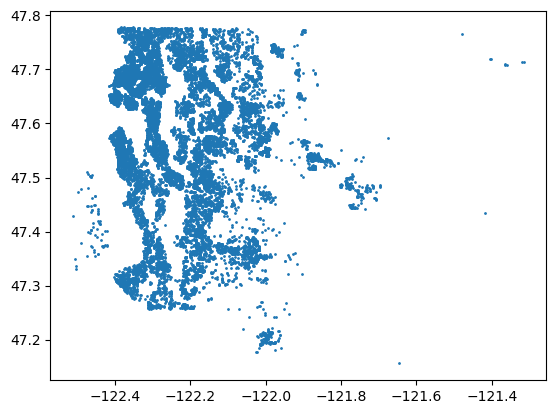

In [174]:
plt.plot(df['long'], df['lat'], 'o', markersize=1)
plt.show()

In [175]:
# X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

## Recherche de Clusters

C:\Users\Ponts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ponts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ponts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

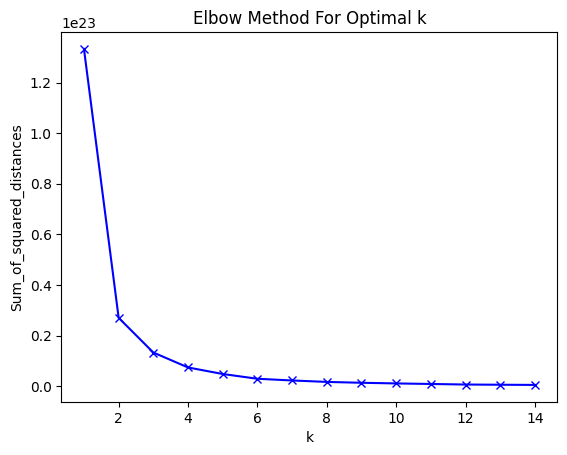

In [176]:
def plot_elbow(X_train, K):
    Sum_of_squared_distances = []
    for k in range(1, K):
        km = KMeans(n_clusters = k, random_state = 0)
        km = km.fit(X_train)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(range(1, K), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

plot_elbow(X, 15)

In [177]:
optimal_k = 4

In [178]:
model = KMeans(n_clusters= optimal_k, random_state=0, n_init="auto")
kmeans = model.fit(X)

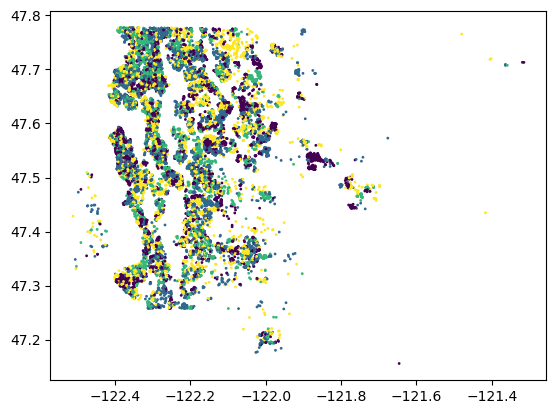

In [179]:
plt.scatter(df['long'], df['lat'], c=kmeans.labels_, cmap='viridis', s = 1)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [180]:
for cluster in range(optimal_k):
    print(cluster, df[kmeans.labels_ == cluster].shape)
    # print(df.loc[kmeans.labels_ == cluster, 'prix'].mean())

0 (4055, 21)
1 (4823, 21)
2 (3029, 21)
3 (4205, 21)


In [181]:
for cluster in range(optimal_k):
    print(cluster, X[kmeans.labels_ == cluster].shape)
    print(X.loc[kmeans.labels_ == cluster, 'm2_interieur'].mean())

0 (4055, 19)
191.22786683107276
1 (4823, 19)
187.72506738544473
2 (3029, 19)
187.45163420270717
3 (4205, 19)
189.93008323424493


## Visualisation de clusters géographiques

In [182]:
Position_df = df[['long', 'lat']]

C:\Users\Ponts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ponts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ponts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

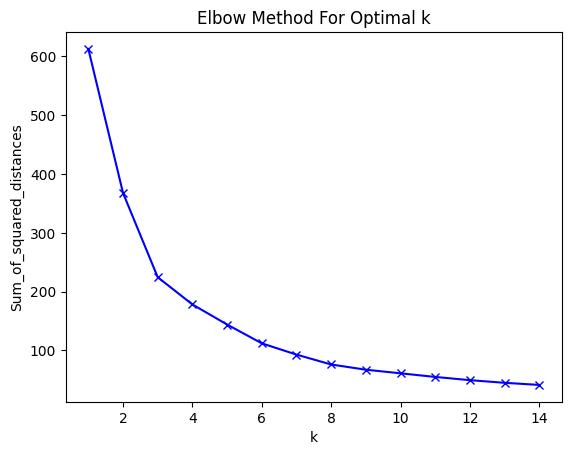

In [183]:
plot_elbow(Position_df, 15)

In [184]:
optimal_k_position = 10
model_p = KMeans(n_clusters= optimal_k_position, random_state=0, n_init="auto")
kmeans_p = model_p.fit(Position_df)

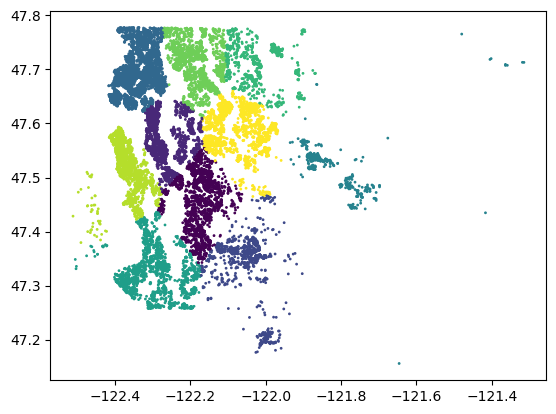

In [185]:
plt.scatter(Position_df['long'], Position_df['lat'], c=kmeans_p.labels_, cmap='viridis', s = 1)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

## Implémentation de modèles de régression polynomiale sur les différents clusters trouvés

In [198]:
params = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 8,
    'eta': 0.35,
    'subsample':0.90,
    'learning_rate':0.05
    }

num_folds = 4  # nombre de plis pour la validation croisée
num_boost_round = 10000  # nombre de tours d'apprentissage

In [199]:
# Create a dictionary to store the models for each cluster
models = {}

# Loop over the unique labels in kmeans.labels_
for cluster in np.unique(kmeans.labels_):
    # Select the data for this cluster
    X_cluster = X[kmeans.labels_ == cluster]
    y_cluster = df.loc[kmeans.labels_ == cluster, 'prix']
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    # do a xgboost on the data
    bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, 'test')], early_stopping_rounds=10, verbose_eval=False)
    models[cluster] = bst
    y_pred = bst.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)

Mean Squared Error: 9673595370.578783
R-squared Score: 0.8751364080455486
Mean Squared Error: 10400307545.936386
R-squared Score: 0.9034260508651619
Mean Squared Error: 11739296578.569221
R-squared Score: 0.8644161148373746
Mean Squared Error: 11085929619.840923
R-squared Score: 0.886118930289826


In [200]:
# # Create a dictionary to store the models for each cluster
# models = {}

# # Loop over the unique labels in kmeans.labels_
# for cluster in np.unique(kmeans.labels_):
#     # Select the data for this cluster
#     X_cluster = X[kmeans.labels_ == cluster]
#     y_cluster = df.loc[kmeans.labels_ == cluster, 'prix']
#     X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)
#     # Create and fit the model
#     model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
#     model.fit(X_train, y_train)

#     # Store the model in the dictionary
#     models[cluster] = model
#     print(cluster, model.score(X_test, y_test))

In [201]:
# Python
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
X_teste = df_test.drop(['date'], axis=1)
X_teste_cluster = kmeans.predict(X_teste)
X_teste_cluster

array([3, 3, 3, ..., 0, 0, 0])

In [202]:

# Create a DataFrame to store the predictions
predictions = pd.DataFrame()

# Loop over the unique labels in X_teste_cluster
for cluster in np.unique(X_teste_cluster):
    # Check if there's a model for this cluster
    if cluster in models:
        # Select the data for this cluster
        X_cluster = X_teste[X_teste_cluster == cluster]
        X_cluster = xgb.DMatrix(X_cluster)
        # Use the model for this cluster to make predictions
        y_pred = models[cluster].predict(X_cluster)

        # Add the predictions to the DataFrame
        predictions = pd.concat([predictions, pd.DataFrame({'id': df_test['id'][X_teste_cluster == cluster], 'prix': y_pred})])

# Save the predictions to a CSV file
predictions.to_csv('Data/result.csv', index=False)